### Library Imports

In [79]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import kpss, adfuller,acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import kurtosis
from pmdarima.arima import auto_arima

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
import random
random.seed(42)
warnings.filterwarnings('ignore')

In [81]:
import scipy
from scipy.signal import periodogram

### Reading Data

In [82]:
sales = pd.read_csv('Dataset/train.csv')
stores = pd.read_csv('Dataset/store.csv')
test = pd.read_csv('Dataset/test.csv')
sales.Date = pd.to_datetime(sales.Date)
sales.set_index('Date', inplace=True)
print(sales.index)
sales.head()

DatetimeIndex(['2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31',
               ...
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01'],
              dtype='datetime64[ns]', name='Date', length=1017209, freq=None)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


### Utility Functions

In [83]:
def plot_periodogram(ts, detrend='linear', ax=None):
    """
    A Utility Function to Plot Periodogram
    """
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots(figsize=(20,20))
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.grid()
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    # return ax

### Plots

Periodogram for open days for store(1)

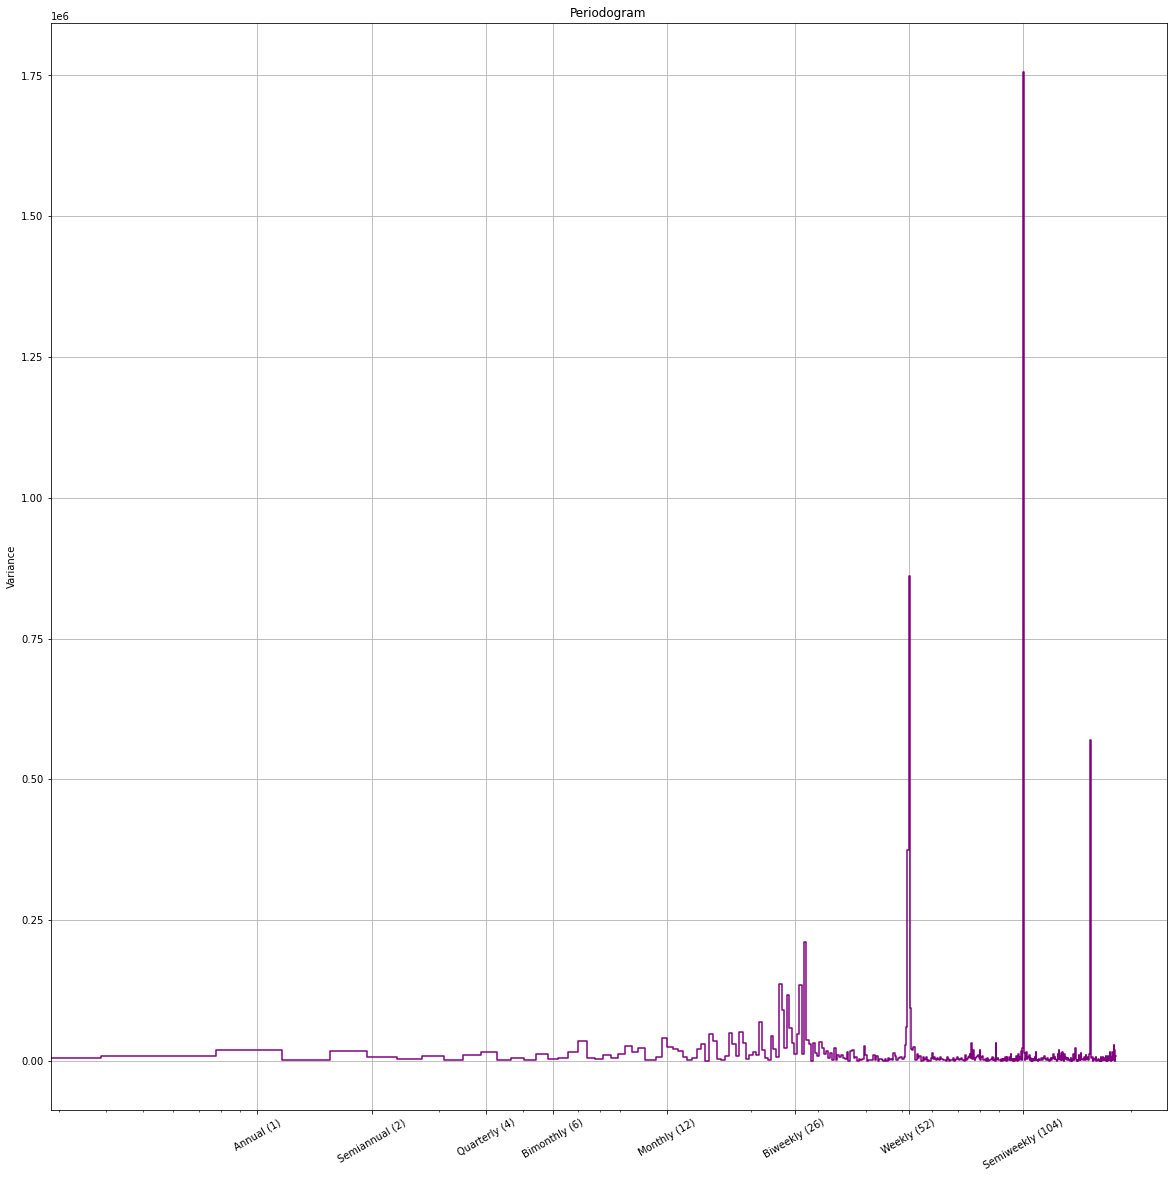

In [114]:

plot_periodogram(sales['Sales'][(sales.Store ==1100)])

ACF Plot for store

In [85]:
# plt.rc("figure", figsize=(20,20))
# plot_acf(sales['Sales'], lags = 100);

In [86]:
# plot_pacf(sales['Sales'], lags = 100);

### Checking the stationarity of the data

#### Utility Function for KPSS

In [87]:
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    if(kpsstest[1] < 0.05):
        print("The series is Non Stationary")
    else:
        print("The series is Stationary")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print(kpss_output)


#### Utility Function for ADF

In [88]:
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    if(dftest[1] > 0.05):
        print(f"The series is Non Stationary (p-value{dftest[1]} > 0.05)")
    else:
        print(f"The series is Stationary (p-value : {round(dftest[1],4) }<= 0.05)")
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [89]:
# def adf_test(timeseries):
#     result = adfuller(timeseries)
#     print('ADF Statistic: %f' % result[0])
#     print('p-value: %f' % result[1])
#     print('Critical Values:')
#     for key, value in result[4].items():
#         print('\t%s: %.3f' % (key, value))

#     if result[0] < result[4]["5%"]:
#         print ("Reject Ho - Time Series is Stationary")
#     else:
#         print ("Failed to Reject Ho - Time Series is Non-Stationary")

#### Running the tests (ALL DAYS)

In [90]:
kpss_test(sales['Sales'][sales.Store == 1 ])

Results of KPSS Test:
The series is Stationary
Test Statistic           0.268694
p-value                  0.100000
#Lags Used               0.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


In [91]:
adf_test(sales["Sales"][sales.Store == 1])

Results of Dickey-Fuller Test:
The series is Stationary (p-value : 0.0003<= 0.05)
Test Statistic                  -4.374784
p-value                          0.000329
#Lags Used                      21.000000
Number of Observations Used    920.000000
Critical Value (1%)             -3.437478
Critical Value (5%)             -2.864687
Critical Value (10%)            -2.568445
dtype: float64


### Running the tests ( OPEN DAYS )

In [92]:
kpss_test(sales['Sales'][sales.Store == 1 ] & ( sales.Open ==1 ))

Results of KPSS Test:
The series is Stationary
Test Statistic             0.09131
p-value                    0.10000
#Lags Used               559.00000
Critical Value (10%)       0.34700
Critical Value (5%)        0.46300
Critical Value (2.5%)      0.57400
Critical Value (1%)        0.73900
dtype: float64


In [93]:
adf_test(sales['Sales'][(sales.Store == 1) & (sales.Open == 1) ])

Results of Dickey-Fuller Test:
The series is Stationary (p-value : 0.0<= 0.05)
Test Statistic                  -5.412786
p-value                          0.000003
#Lags Used                      13.000000
Number of Observations Used    767.000000
Critical Value (1%)             -3.438905
Critical Value (5%)             -2.865316
Critical Value (10%)            -2.568781
dtype: float64


#### The tests suggest the data is differencing stationary

In [94]:
# decom_store1 = seasonal_decompose(sales["Sales"][sales.Store == 3], period=15, extrapolate_trend='freq')

In [95]:
# decom_store1.plot()

In [96]:
# plt.figure(figsize=(10,10))
# decom_store1.resid[0:100].plot()

In [97]:
# adf_test(decom_store1.resid)
# kpss_test(decom_store1.resid)

# Fitting a Univariate Arima Model

### Preparing the data for prediction 
1. Select only the sales column from data

In [208]:
df_sales = sales[['Store', 'Sales', 'Open']]
store_no = 99
df = df_sales.Sales[df_sales.Store ==store_no ]
df_open = df_sales.Sales[(df_sales.Store ==store_no) & (df_sales.Open == 1) ]
df.sort_index(ascending= True, inplace= True)
df_open.sort_index(ascending= True, inplace= True)
df.index

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2015-07-22', '2015-07-23', '2015-07-24', '2015-07-25',
               '2015-07-26', '2015-07-27', '2015-07-28', '2015-07-29',
               '2015-07-30', '2015-07-31'],
              dtype='datetime64[ns]', name='Date', length=758, freq=None)

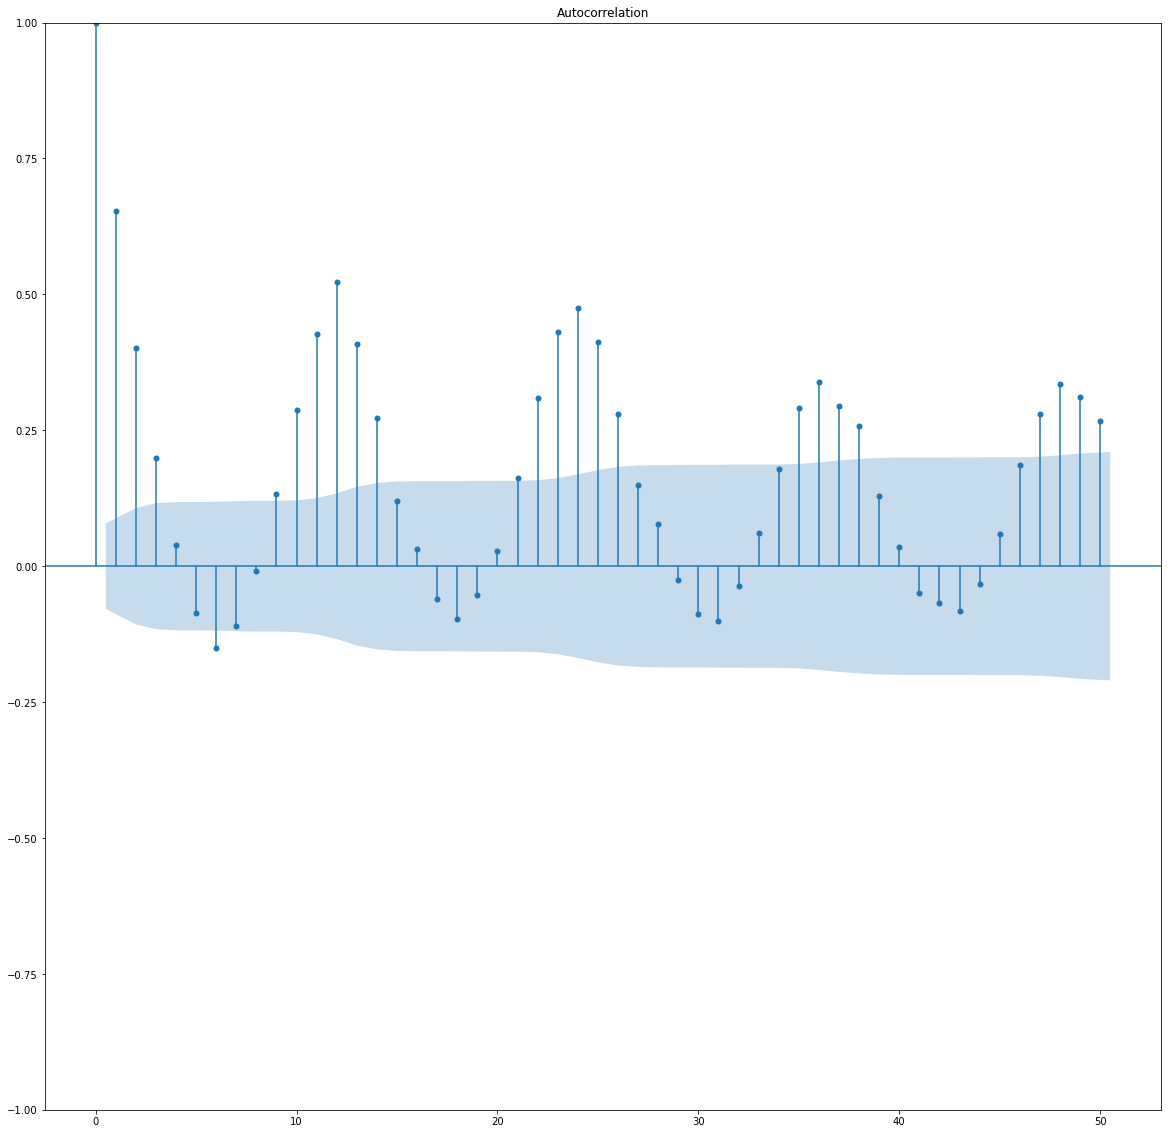

In [213]:
# ACF/PACF for open days
plot_acf(df_open, lags = 50)
plt.show()

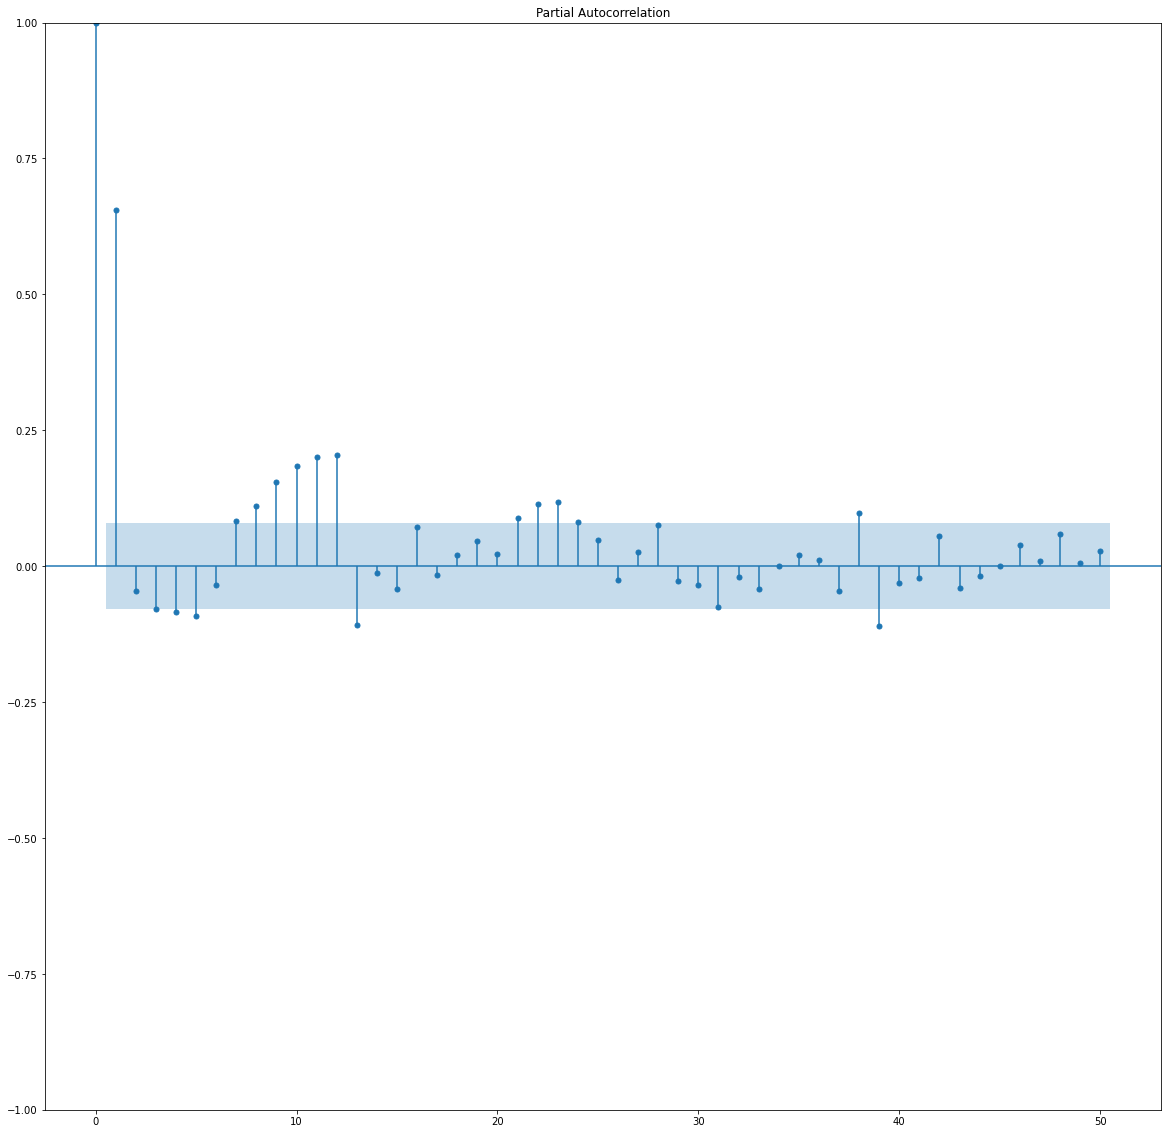

In [214]:
# ACF/PACF for open days
plot_pacf(df_open, lags = 50)
plt.show()

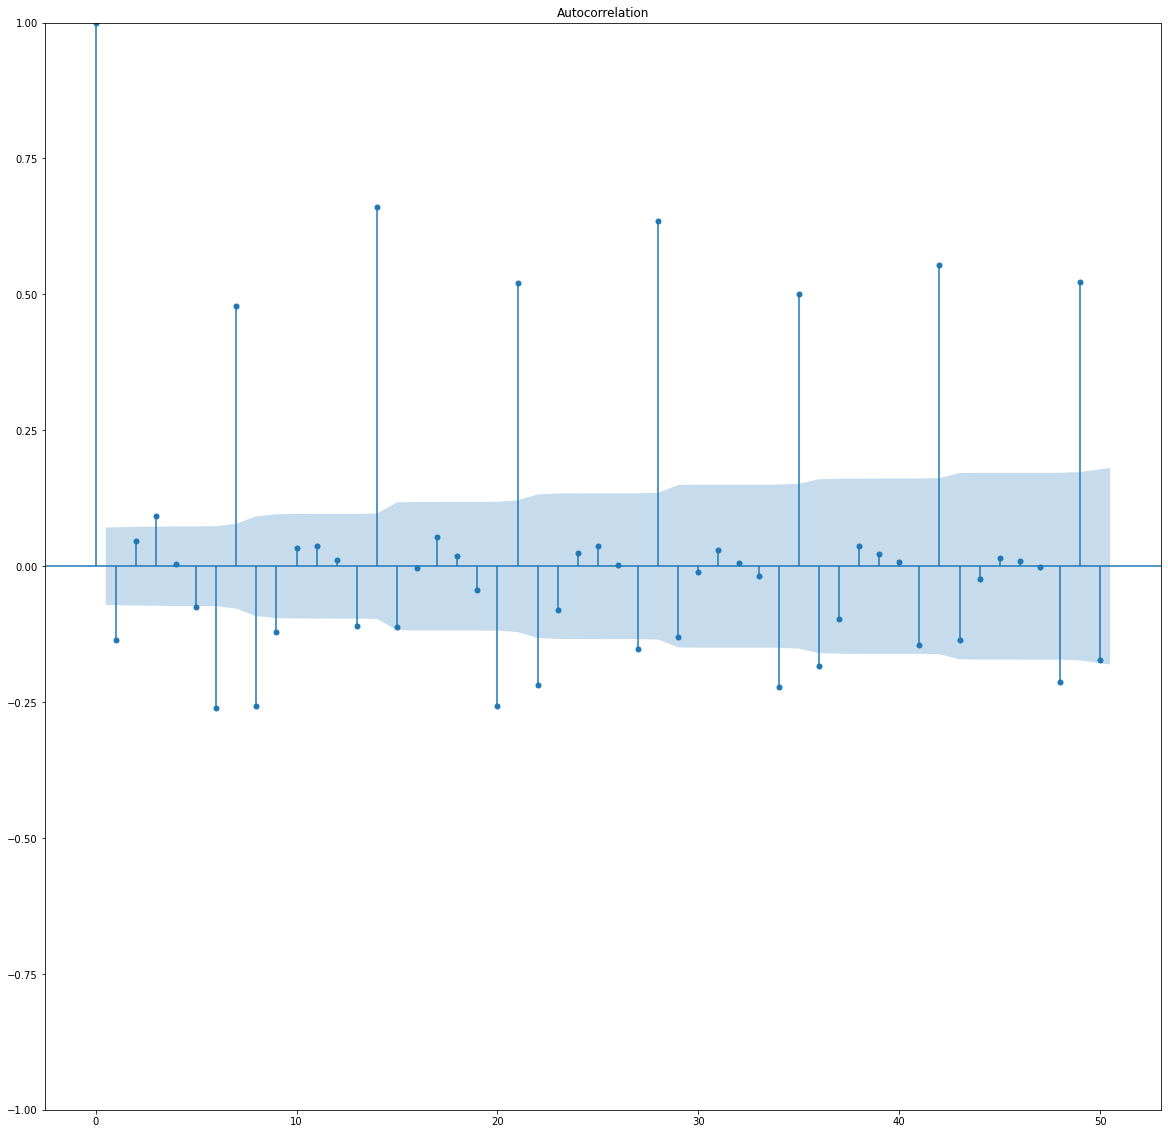

In [215]:
# ACF/PACF for all days
plot_acf(df, lags =  50)
plt.show()

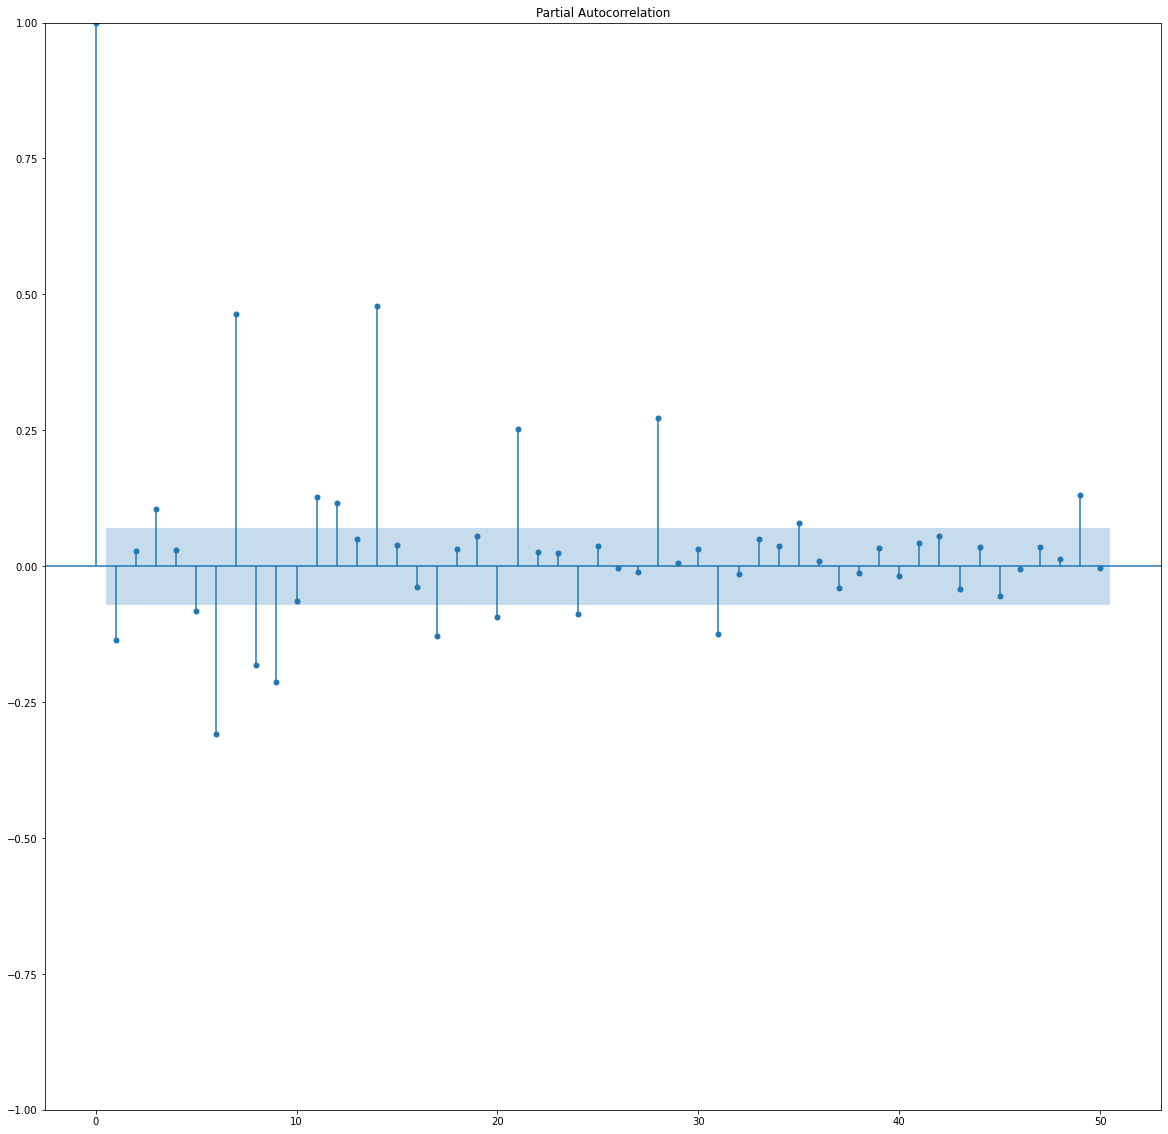

In [216]:
# ACF/PACF for all days
plot_pacf(df, lags = 50)
plt.show()

Results of KPSS Test:
The series is Stationary
Test Statistic           0.004491
p-value                  0.100000
#Lags Used               4.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


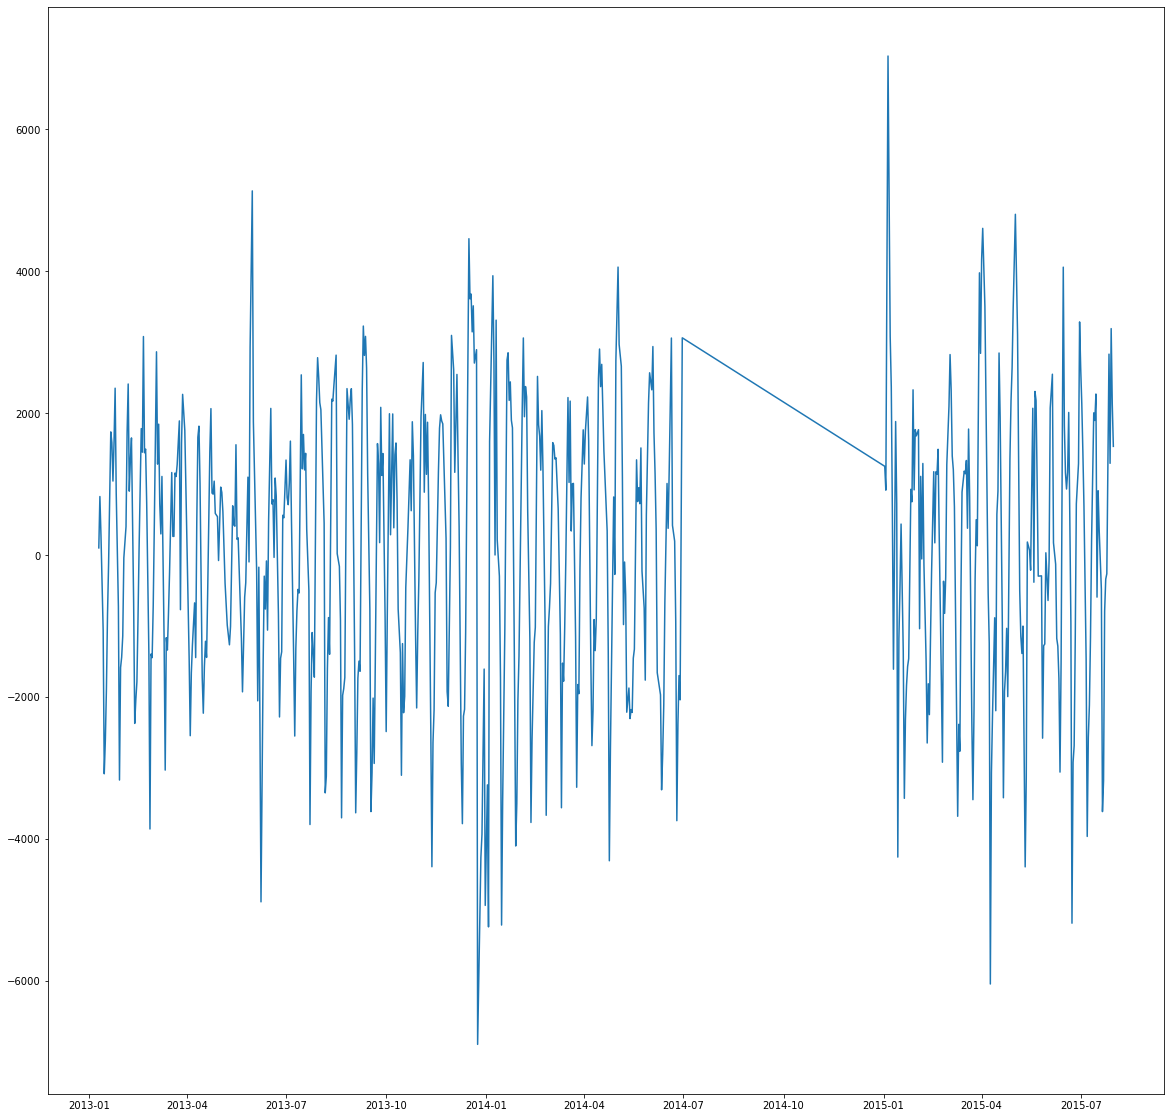

In [233]:
diff_df_open = df_open.diff(periods=7)

plt.plot(diff_df_open)
kpss_test(diff_df_open.dropna())

In [217]:
train_data, test_data = df[0:-42], df[-42:]
test_data_copy = test_data.copy()
training_data = train_data.values
test_data = test_data.values
history = [x for x in training_data]
model_predictions = []
N_test_observations = len(test_data)
for time_point in range(N_test_observations):
    model = ARIMA(history, order=(5,0,2))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)


In [102]:
test_data_copy = test_data_copy.to_frame()

In [103]:
test_data_copy['pred'] = model_predictions

In [104]:
def eval_metrics(actual_val, predicted_val):
    """
    Returns the MSE, MAE and RMSE Error for the given values
    Parameters:
    * actual_val    : The actual value of the data
    * predicted_val : The predicted value of the data
    returns:
    errors<Tuple> : A tuple of MSE MAE and RMSE score for the data (MSE, MAE, RMSE)
    """
    mse     = (np.square(actual_val - predicted_val)).mean()
    mae     = (np.abs(actual_val - predicted_val)).mean()
    rmse    = np.sqrt(mse)
    errors  = (mse,mae,rmse)
    return errors

def print_eval_metrics(actual_val, predicted_val):
    mse,mae,rmse = eval_metrics(actual_val, predicted_val)
    print(f"\nThe Mean Squared Error(MSE) : {mse}")
    print(f"\nThe Mean Absolute Error(MAE) : {mae}")
    print(f"\nThe Root Mean Squared Error(RMSE) : {rmse}")

In [105]:
print_eval_metrics(test_data_copy['pred'], test_data_copy.Sales)


The Mean Squared Error(MSE) : 2862366.64544959

The Mean Absolute Error(MAE) : 1400.3779229222123

The Root Mean Squared Error(RMSE) : 1691.8530212313333


### Auto ARIMA

In [106]:
#     model_autoARIMA = auto_arima(df_open, start_p=0, start_q=0,
#     test='adf',
#     # use adftest to find osales_combined.Sales - sales_combined.predptimal 'd'
#     max_p=10, max_q=10, # maximum p and q
#     m=1,
#     # frequency of series
#     seasonal=False,
#     # No Seasonality
#     start_P=0,
#     D=0,
#     trace=True,
#     error_action='ignore',
#     suppress_warnings=True,
#     stepwise=True)
#     print(model_autoARIMA.summary())
#     model_autoARIMA.plot_diagnostics(figsize=(15,8))
#     plt.show()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=13028.092, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=12540.652, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=12734.398, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=15479.610, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=12542.065, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=12542.364, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=12530.057, Time=0.16 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=12525.050, Time=0.51 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=12530.952, Time=0.15 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=12515.075, Time=0.31 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=12525.104, Time=0.15 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=12485.093, Time=0.44 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=12484.015, Time=0.24 sec
 ARIMA(6,0,0)(0,0,0)[0] intercept   : AIC=12483.148, Time=0.29 sec
 ARIMA(7,0,0)(0,0,0

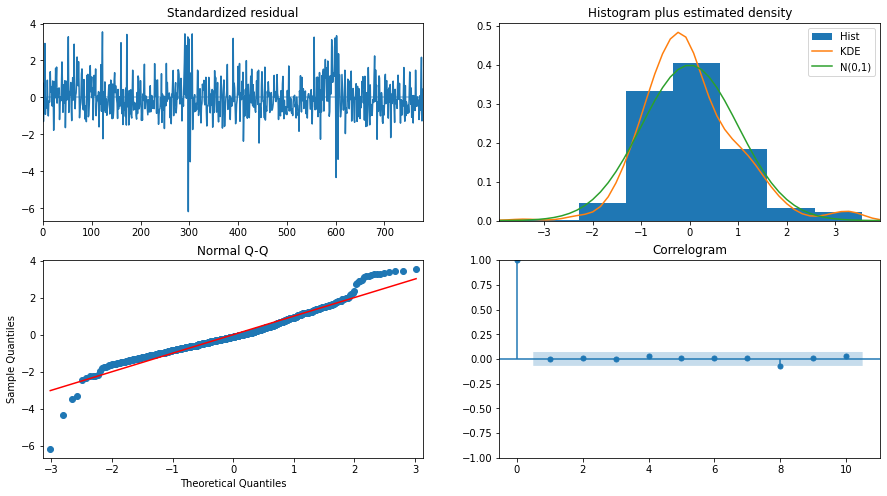

In [205]:
model_autoarima = auto_arima(df_open, start_p=0, d=None, start_q=0, max_p=10, max_q=10,
                          start_P=1, D=None, start_Q=1, max_P=10, max_Q=10, max_order=30,
                          m=1, seasonal=True, stationary=False, information_criterion='aic', alpha=0.05,
                          test='kpss', stepwise=True, trace = True)
print(model_autoarima.summary())
model_autoarima.plot_diagnostics(figsize=(15,8))
plt.show()


In [237]:
model_autoarima.order

(6, 0, 0)

In [198]:
model_1=ARIMA(df_open,order=(0,0,7))
model_fit=model_1.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  781
Model:                 ARIMA(0, 0, 7)   Log Likelihood               -6233.006
Date:                Mon, 20 Feb 2023   AIC                          12484.012
Time:                        15:16:43   BIC                          12525.958
Sample:                             0   HQIC                         12500.144
                                - 781                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4759.1254     96.664     49.234      0.000    4569.667    4948.584
ma.L1          0.7146      0.027     26.174      0.000       0.661       0.768
ma.L2          0.5596      0.044     12.695      0.000       0.473       0.646
ma.L3          0.2787      0.045      6.246      0.000       0.191       0.366
ma.L4          0.4167      0.042      9.923      0.000       0.334       0.499
ma.L5          0.1817      0.044      4.129      0.000       0.095       0.268
ma.L6          0.1319      0.041      3.249      0.001       0.052       0.211
ma.L7          0.0211      0.031      0.669      0.503      -0.041       0.083
sigma2          5e+05   1.86e+04     26.875      0.000    4.64e+05    5.36e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               381.26
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.15   Skew:                             0.17
Prob(H) (two-sided):                  0.26   Kurtosis:                         6.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [199]:
len(df_open)

781

### Prediction 
1. Pred : With Dynamic = True
2. pred_1: With Dynamic = False

In [200]:
pred = model_fit.predict(start =740 , end= 781, dynamic= True)  
pred_1 = model_fit.predict(start = 740, end= 781, dynamic= False)  

In [201]:
df_open[-42:]

Date
2015-06-13    4256
2015-06-15    5518
2015-06-16    4852
2015-06-17    4000
2015-06-18    4645
2015-06-19    4202
2015-06-20    4097
2015-06-22    3846
2015-06-23    3762
2015-06-24    3346
2015-06-25    3533
2015-06-26    3317
2015-06-27    4019
2015-06-29    5197
2015-06-30    5735
2015-07-01    5223
2015-07-02    5558
2015-07-03    4665
2015-07-04    4797
2015-07-06    4359
2015-07-07    3650
2015-07-08    3797
2015-07-09    3897
2015-07-10    3808
2015-07-11    3530
2015-07-13    5054
2015-07-14    5042
2015-07-15    4767
2015-07-16    4427
2015-07-17    4852
2015-07-18    4406
2015-07-20    4395
2015-07-21    3558
2015-07-22    3464
2015-07-23    3769
2015-07-24    3706
2015-07-25    4364
2015-07-27    6102
2015-07-28    5011
2015-07-29    4782
2015-07-30    5020
2015-07-31    5263
Name: Sales, dtype: int64

In [202]:
print_eval_metrics(pred, df_open[-42:].values)
print_eval_metrics(pred_1, df_open[-42:].values)



The Mean Squared Error(MSE) : 615116.9307446916

The Mean Absolute Error(MAE) : 654.737537178163

The Root Mean Squared Error(RMSE) : 784.2939058444173

The Mean Squared Error(MSE) : 63579.802278715164

The Mean Absolute Error(MAE) : 202.26251029873163

The Root Mean Squared Error(RMSE) : 252.15035649135055


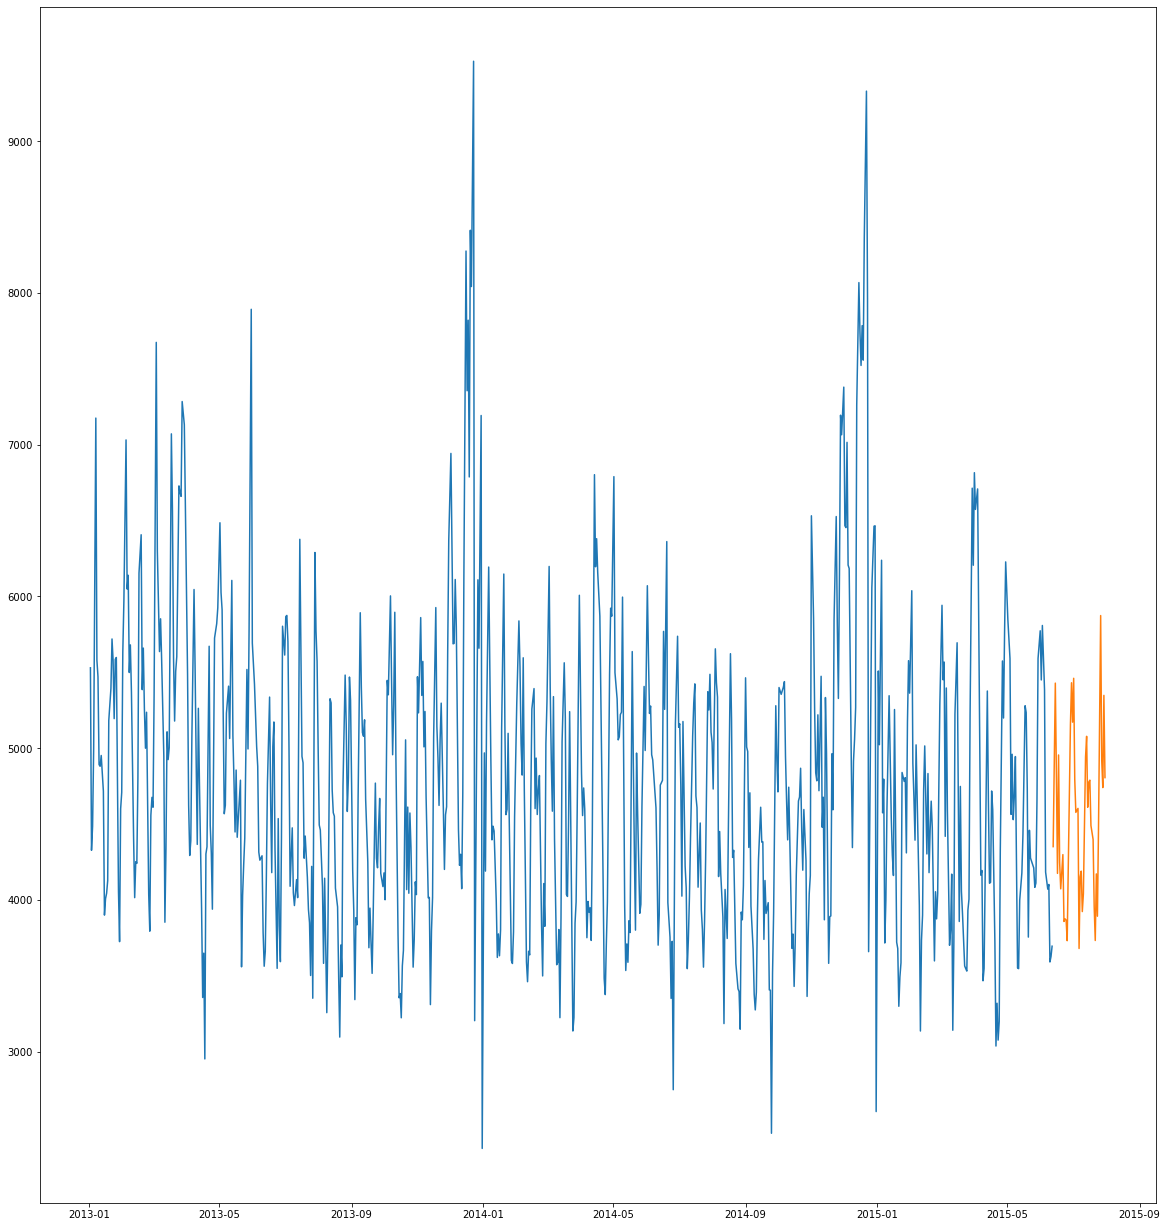

In [203]:
plt.figure(figsize=(20,22))
plt.plot(df_open[:-42])
plt.plot(df_open.index[-42:],pred_1)

In [235]:
len(sales.Store.value_counts())

1115